### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

### Load the dataframe

In [2]:
data = pd.read_csv('data_altered.csv',sep=';')

In [3]:
df=pd.DataFrame()

#### Doing some cleaning and pre-processing on the data

In [4]:
df = data.copy()
df = df[df.CLUB_DT != 0]
df = df[df.NS != 0]
#df = df.drop(columns= 'Unnamed: 0')
# pd.set_option('display.max_columns', None)
# changing from european to english notation : ',' to '.'
for i in ['NS', 'NS Capsules', 'NS Original Line','NS Vertuo Line', 'NS Machines', 'NS After Sales', 'Allowances','TAX_AMNT','UNIT_PRICE']:
    df[i] = df[i].str.replace(',', '.').astype(float)
print('I am here')
# datevarialbes to datetime format
df['MAIN_DATE_DISP']= pd.to_datetime(df['MAIN_DATE_DISP']).dt.date  
df['CLUB_DT_DISP']= pd.to_datetime(df['CLUB_DT_DISP']).dt.date  
print('I am here')
# Getting Years/Months from the date columns
df['get_Y'] = df.CLUB_DT.astype(str).str[:4].astype(int)
df['order_Y'] = df.MAIN_DATE.astype(str).str[:4]
df['proc_Y'] = df.PROC_DT.astype(str).str[:4]
df['order_M']=df.MAIN_DATE.astype(str).str[4:6].astype(int)
print('I am here')
df['proc_M'] = df.PROC_DT.astype(str).str[4:6]
df = df[df.get_Y<2019] #eliminate year >2019 as they are not supposed to be existant: Must be false entries
df = df[df.get_Y>2006]
#changing THIRD and ORD to str, as they are not summable
df.THIRD = df.THIRD.astype(str)
df.ORD = df.ORD.astype(str) 

print('I am here')
df = df.rename(columns={'NS Capsules':'NS_CAPSULES', 'NS Machines':'NS_MACHINES','NS After Sales':'NS_After'})
#eliminating rows with no CLUB_DT and no NS
df = df[df.CLUB_DT != 0]
df = df[df.NS != 0]
print('I am here')
# getM after eliminating nan values 
df['get_M']=df.CLUB_DT.astype(str).str[4:6].astype(int)

I am here
I am here
I am here
I am here
I am here


In [5]:
print("Shape of dataframe:", df.shape)

Shape of dataframe: (1530707, 89)


### Grouping Data by Month to check seasonality of Sales

In [6]:
byMonth = df.groupby(['order_M'])['TOTAL_OF_CAPSULES','TOTAL_OF_MACHINES','TOTAL_OF_ACCESSORIES','NS', 'NS_CAPSULES','NS_MACHINES','MACHINE_PLACED','MACHINE_PLACED_SOLD','MACHINE_PLACED_FREE','MACHINE_PLACED_CANCELLED','MACHINE_PLACED_IN_ROOM_CANCELLED',
       'MACHINE_PLACED_SOLD_CANCELLED'].sum().reset_index()

In [7]:
len(df)

1530707

In [8]:
df.NS.sum()

122153715.11267003

In [9]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=byMonth['order_M'], y=byMonth['NS_MACHINES'],
                    mode='lines+markers',line=dict(color='blue',dash='dash'),
                    name='NS of MACHINES'), secondary_y=True,)
fig.add_trace(go.Scatter(x=byMonth['order_M'], y=byMonth['NS'],
                    mode='lines+markers',line=dict(color='red'),
                    name='NS'))
fig.add_trace(go.Scatter(x=byMonth['order_M'], y=byMonth['NS_CAPSULES'],
                    mode='lines+markers', line=dict(color='green',dash='dash'),
                    name='NS_CAPSULES'))


fig.update_xaxes(title_text="Month of Order")
fig.update_yaxes(title_text="<b>Accumulated Sales (also for Capsules)", secondary_y=False)
fig.update_yaxes(title_text="<b>NS of Machines</b> in blue", secondary_y=True)

### Grouping Data by Get-Year

In [10]:
byYear1 = df.groupby(['get_Y'])['TOTAL_OF_CAPSULES','TOTAL_OF_MACHINES','TOTAL_OF_ACCESSORIES','NS', 'NS_CAPSULES','NS_MACHINES','MACHINE_PLACED','MACHINE_PLACED_SOLD','MACHINE_PLACED_FREE'].sum().reset_index()
byYear2 = df.groupby(['get_Y'])['THIRD_CAT1_DESCR','THIRD_STATUS_DESCR'].min().reset_index()
from functools import reduce
dfs = [byYear1,byYear2]
byYear = reduce(lambda  left,right: pd.merge(left,right,on=['get_Y'],
                                            how='inner'), dfs)

In [11]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=byYear['get_Y'], y=byYear['NS_MACHINES'],
                    mode='lines+markers',line=dict(color='blue',dash='dash'),
                    name='NS of MACHINES'),secondary_y=True,)
fig.add_trace(go.Scatter(x=byYear['get_Y'], y=byYear['NS'],
                    mode='lines+markers',line=dict(color='red'),
                    name='NS'))
fig.add_trace(go.Scatter(x=byYear['get_Y'], y=byYear['NS_CAPSULES'],
                    mode='lines+markers',line=dict(color='green',dash='dash'),
                    name='NS_CAPSULES'))
fig.update_xaxes(title_text="Year of First Order")
fig.update_yaxes(title_text="<b>Accumulated Sales (+Capsules)</b> in blue", secondary_y=False)
fig.update_yaxes(title_text="<b>NS of Machines</b> in red", secondary_y=True)

### Grouping Data by Client

## By Client/THIRD

#### getting total amount of NS (+ for Capsules and Machines, and After Sales), Allowances, Machines Placed & Machines Cancelled 

In [12]:
cli = df.groupby(['THIRD'])['NS', 'NS_CAPSULES','NS_MACHINES','NS_After','Allowances','MACHINE_PLACED','MACHINE_PLACED_CANCELLED','TAX_AMNT'
                           ].sum().reset_index().sort_values(by='THIRD')

#### getting non-summable variables :  get Year/Month, the first Month of order, the category of the Client and its status

In [13]:
cli[['get_Y','get_M','order_M','THIRD_CAT1_DESCR','THIRD_STATUS_DESCR']] = df.groupby(['THIRD'])['get_Y','get_M','order_M','THIRD_CAT1_DESCR','THIRD_STATUS_DESCR'].min().reset_index().sort_values(by='THIRD')[['get_Y','get_M','order_M','THIRD_CAT1_DESCR','THIRD_STATUS_DESCR']]

#### getting the average amount of orders by client

In [14]:
cli['nORD']=df.groupby(['THIRD','ORD'])['NS'].count().reset_index().groupby(['THIRD'])['ORD'].count().reset_index().sort_values(by='THIRD')['ORD']

#### getting average NS (+ for Capsules and Machines, and After Sales) and Allowances

In [15]:
cli[['AVG_NS_p_ORD','AVG_CAPSULES_p_ORD','AVG_MACHINES_p_ORD','AVG_After_p_ORD','AVG_Allowances_p_ORD','AVG_TAX', 'AVG_UnP']]= df.groupby(['THIRD','ORD'])[
    'NS','NS_CAPSULES','NS_MACHINES','NS_After','Allowances','TAX_AMNT', 'UNIT_PRICE'].sum().reset_index().groupby(['THIRD'])[
    'NS','NS_CAPSULES','NS_MACHINES','NS_After','Allowances','TAX_AMNT', 'UNIT_PRICE'].mean().reset_index().sort_values(by='THIRD')[[
    'NS','NS_CAPSULES','NS_MACHINES','NS_After','Allowances','TAX_AMNT', 'UNIT_PRICE']]

## Checking for nan values

In [16]:
count_missing = cli.isnull().sum() 

percent_missing = (cli.isnull().sum()/len(df))*100

missing_values = pd.concat([percent_missing,count_missing], axis=1,
                           keys=['Percent_of_Missing_Values', 'Count_of_Missing_Values'])
# missing_values

## Checking for outliers

In [17]:
num_vars= [#'THIRD',
 'NS',
 'NS_CAPSULES',
# 'NS_MACHINES',
# 'NS_After',
 'Allowances',
# 'MACHINE_PLACED',
# 'MACHINE_PLACED_CANCELLED',
 'TAX_AMNT',
# 'get_Y',
# 'get_M',
# 'order_M',
# 'THIRD_CAT1_DESCR',
# 'THIRD_STATUS_DESCR',
 'nORD',
 'AVG_NS_p_ORD',
 'AVG_CAPSULES_p_ORD',
# 'AVG_MACHINES_p_ORD',
# 'AVG_After_p_ORD',
 'AVG_Allowances_p_ORD',
 'AVG_TAX',
 'AVG_UnP']

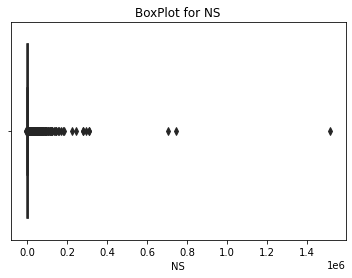

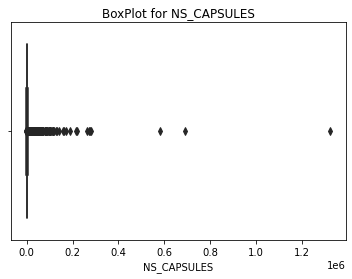

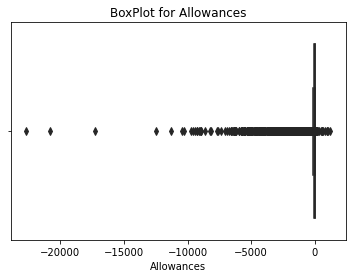

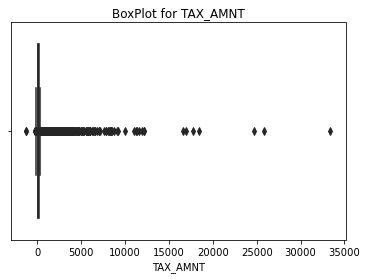

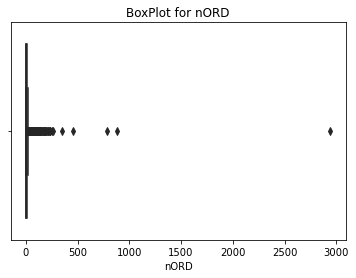

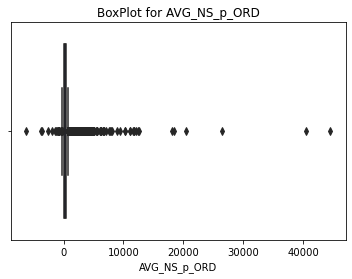

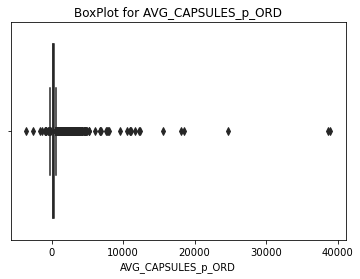

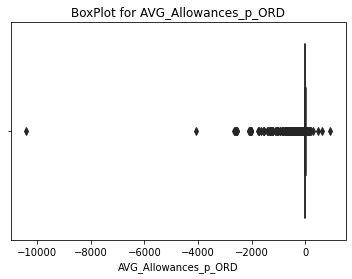

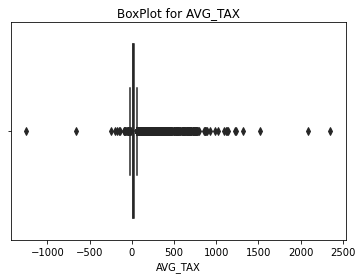

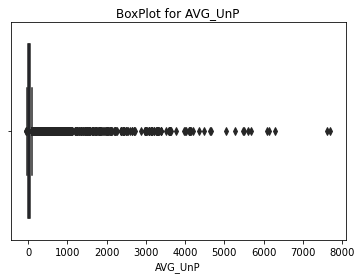

In [18]:
for i in num_vars:
    sns.boxplot(cli[i], palette='dark')
    plt.title('BoxPlot for {}'.format(i))
    plt.show()

From the above boxplots, we can see there are outliers present. Shall transform the data by applying PowerTransformer to treat for outliers. By using IQR Method or Z-score to cap the outliers would have deleted those respective values. Hence, transforming the data.

In [19]:
for x in num_vars:
    q75,q25 = np.percentile(cli.loc[:,x],[95,5])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    cli.loc[cli[x] < min,x] = np.nan
    cli.loc[cli[x] > max,x] = np.nan

In [20]:
print('Number of outliers per column:\n\n',cli.isnull().sum())

Number of outliers per column:

 THIRD                         0
NS                          553
NS_CAPSULES                 590
NS_MACHINES                   0
NS_After                      0
Allowances                  572
MACHINE_PLACED                0
MACHINE_PLACED_CANCELLED      0
TAX_AMNT                    620
get_Y                         0
get_M                         0
order_M                       0
THIRD_CAT1_DESCR              0
THIRD_STATUS_DESCR            0
nORD                        379
AVG_NS_p_ORD                359
AVG_CAPSULES_p_ORD          282
AVG_MACHINES_p_ORD            0
AVG_After_p_ORD               0
AVG_Allowances_p_ORD        901
AVG_TAX                     397
AVG_UnP                     628
dtype: int64


In [21]:
cli = cli.dropna()

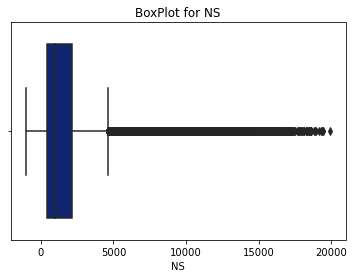

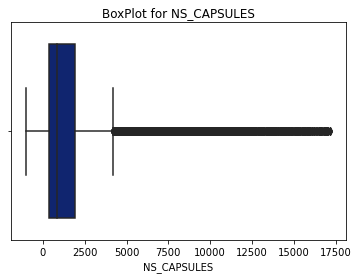

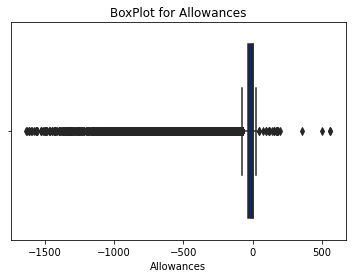

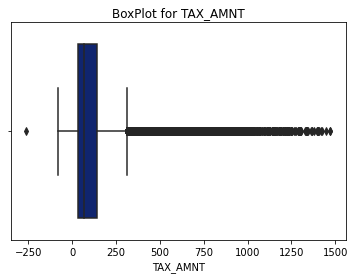

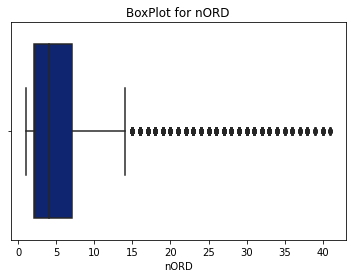

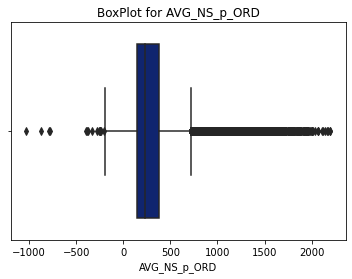

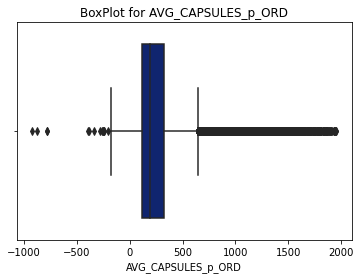

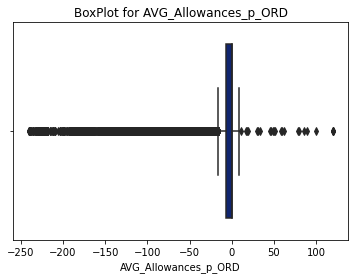

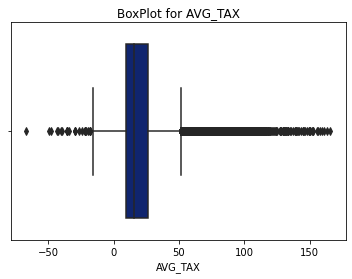

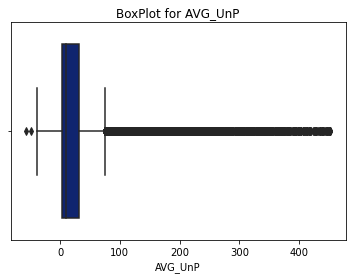

In [22]:
for i in num_vars:
    sns.boxplot(cli[i], palette='dark')
    plt.title('BoxPlot for {}'.format(i))
    plt.show()

## Creating various KPIs

#### 1. Create Dummys for Machine Placed and Machine Cancelled

In [23]:
cli['nM_PLACED'] = np.where((cli.MACHINE_PLACED >0),1,0)
cli['nM_CANCELLED'] = np.where((cli.MACHINE_PLACED_CANCELLED >0),1,0)
cli= cli.drop(columns=['MACHINE_PLACED','MACHINE_PLACED_CANCELLED'])

In [24]:
cli[['nM_PLACED','nM_CANCELLED']].value_counts()

nM_PLACED  nM_CANCELLED
0          0               38980
1          0                8876
           1                 118
0          1                  26
dtype: int64

#### 2. Create Dummy Variable for HORECA & OFFICE (Client Category)

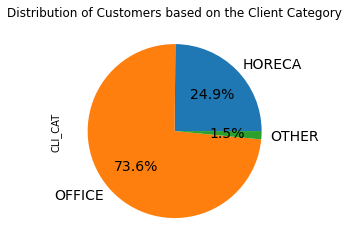

In [25]:
# Plotting the distribution of customer on basis of Purhcase Type
cli['CLI_CAT']=np.where(cli.THIRD_CAT1_DESCR == 'OFFICE','OFFICE',
                       np.where(cli.THIRD_CAT1_DESCR=='HORECA','HORECA','OTHER'))
cli['CLI_CAT'].value_counts().sort_index().plot(kind='pie',autopct='%1.01f%%', 
                     fontsize=14)
plt.title('Distribution of Customers based on the Client Category')
plt.show()

we have very little clients, that are neither part of HORECA or OFFICE, we will drop them

In [26]:
#cli = cli[cli.CLI_CAT!='OTHER']

In [27]:
cli_cat = pd.get_dummies(cli['CLI_CAT'], drop_first=False)
cli1 = pd.merge(cli,cli_cat,left_index=True,right_index=True)
cli = cli1.drop(columns=['THIRD_CAT1_DESCR','CLI_CAT','OFFICE'])

#### 3. Creating a Dummy Variable for Acitve & Non-Active Clients

In [28]:
#px.histogram(cli,x='THIRD_STATUS_DESCR')
#We can see that other than Active or Inactive are very few cases, thus we create a dummy for Active or Inactive(including all other)
cli['CLI_ACTIVE']=np.where(cli.THIRD_STATUS_DESCR == 'Active',1,0)
cli = cli.drop(columns=['THIRD_STATUS_DESCR'])

#### 4.Create a Variable for the Variability of order

To calculate the Variability of orders we multiply the number of unique different items ordered per order with the number of orders over the number of orders.

In [29]:
cli['n_PCat_1'] = df.groupby(['THIRD'])[
    'PROD_CAT_H1_DESCR'].nunique().reset_index().sort_values(by='THIRD')['PROD_CAT_H1_DESCR']
cli['var_PCAT1']=(cli['nORD']*cli['n_PCat_1'])/cli['nORD']

In [30]:
cli =cli.drop(columns='n_PCat_1')

#### 5. Create Variable to measures the average time difference between orders

For each order from each client, we calculate the number of days that have passed since the last order. We then average across the number of days between each order for each client

In [31]:
cli_temp=cli.copy()

In [32]:
d1 = df.groupby(['THIRD','ORD'])['MAIN_DATE_DISP'].min().reset_index()
d1 = d1.sort_values(by=['THIRD', 'MAIN_DATE_DISP'])
d1['time_diff']= np.where(d1.THIRD.eq(d1.THIRD.shift()), 
                          d1["MAIN_DATE_DISP"].diff().apply(lambda x: x/np.timedelta64(1, 'D')).fillna(0).astype('int64'), 
                          'FIRST ORDER')
d1 = d1[d1.time_diff != 'FIRST ORDER']
d1.time_diff = d1.time_diff.astype(int)
d1 = d1.groupby(['THIRD'])['time_diff'].mean().reset_index()
d1['avg_time_diff'] = (365-d1.time_diff)/365

cli = pd.merge(cli_temp,d1[['THIRD','avg_time_diff']], on=['THIRD'],how='left')

#### 6. Create Variable for the Number of Orders per Months active

 Another way to apprach frequency is to divide the total amount of active months of the client by the number of orders. 

In [33]:
cli['avg_ord_pM']=cli.nORD/(13-cli.order_M)
cli.avg_time_diff =cli.avg_time_diff.fillna(0)

#### 7. Create Dummmy for whether Client is part of a bigger group or not

This dummy variable captures whether the client is part of a bigger group or not

In [34]:
cli['Master1']=df.groupby(['THIRD'])['MASTER_CONTROL'].first().reset_index().sort_values(by='THIRD')['MASTER_CONTROL']
cli['Master']= np.where(cli.Master1.isnull(),0,1)

In [35]:
#cli = cli.drop(columns='Master1')

### Analyzing relationship among the different Variables

In [36]:
df=cli[[#'THIRD',
 'NS',
 'NS_CAPSULES',
 'NS_MACHINES',
 'NS_After',
 'Allowances',
 'TAX_AMNT',
# 'get_Y',
# 'get_M',
# 'order_M',
 'nORD',
 'AVG_NS_p_ORD',
 'AVG_CAPSULES_p_ORD',
 'AVG_MACHINES_p_ORD',
 'AVG_After_p_ORD',
 'AVG_Allowances_p_ORD',
 'AVG_TAX',
 'AVG_UnP',
 'nM_PLACED',
 'nM_CANCELLED',
 'HORECA',
# 'OTHER',
# 'CLI_ACTIVE',
 'var_PCAT1',
 'avg_time_diff',
 'avg_ord_pM',
 'Master']]

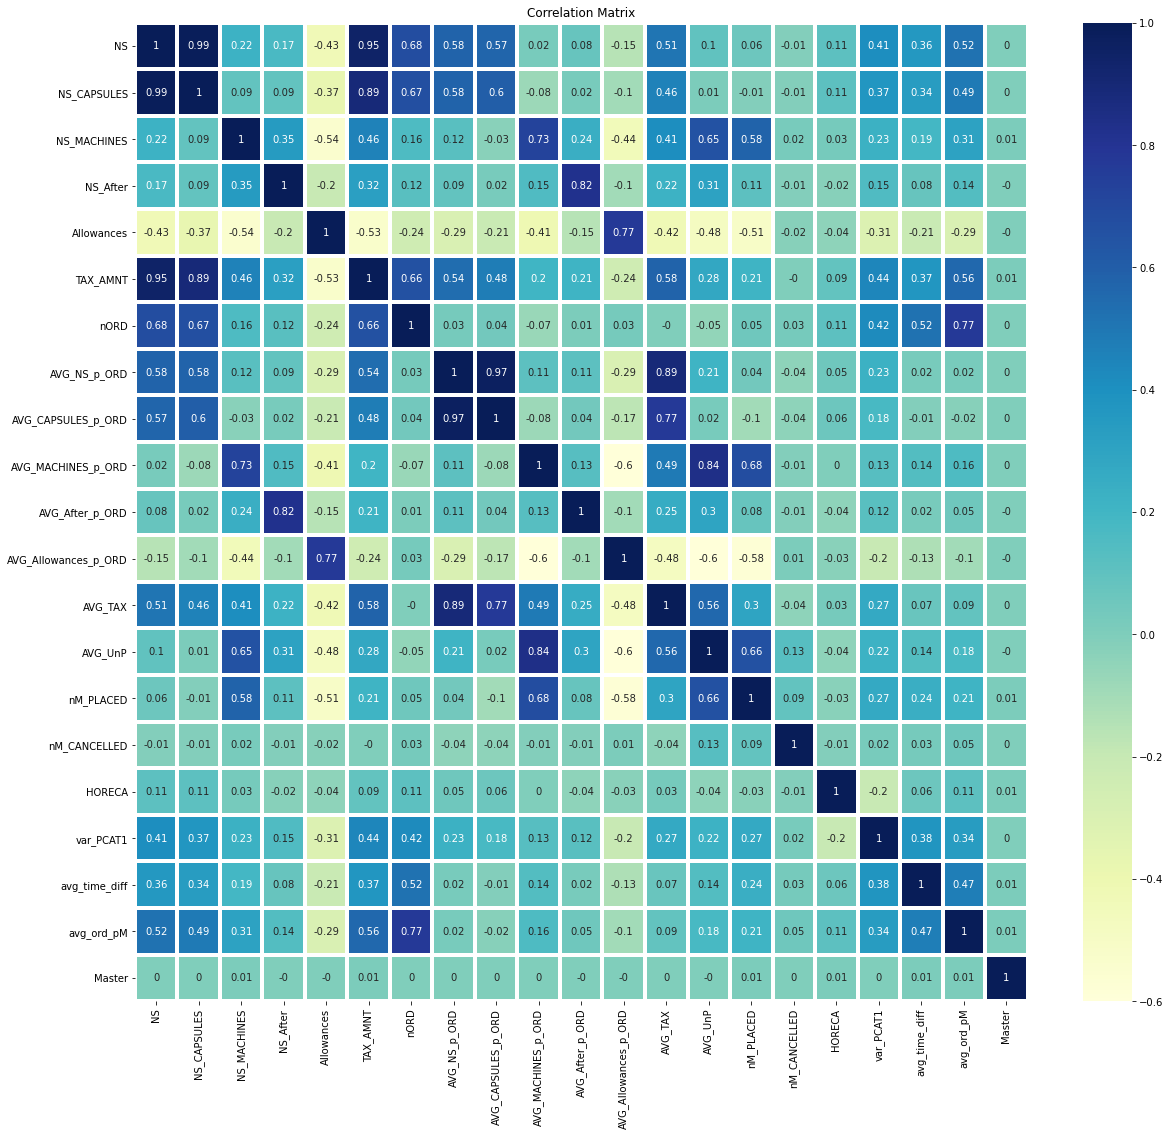

In [37]:
plt.figure(figsize=(20,18))
sns.heatmap(round(df.corr(),2),annot=True, cmap='YlGnBu', linewidths=3, fmt='.2g')
plt.title('Correlation Matrix')
plt.savefig('heatmap.png')
# plt.show()


As one might expect, we have very strong correlations among variables. For examples the overal Net Sales and the Sales of Capusles have a correlation of over 83%. We thus need to reduce the dimensionality of the data.

In [38]:
# Plotting Pair Plot 
#sns.pairplot(df)
#plt.show()

In [39]:
num_vars=['NS',
 'NS_CAPSULES',
 'NS_MACHINES',
 'NS_After',
 'Allowances',
 'TAX_AMNT',
 'nORD',
 'AVG_NS_p_ORD',
 'AVG_CAPSULES_p_ORD',
 'AVG_MACHINES_p_ORD',
 'AVG_After_p_ORD',
 'AVG_Allowances_p_ORD',
 'AVG_TAX',
 'AVG_UnP',
# 'nM_PLACED',
# 'nM_CANCELLED',
# 'HORECA',
# 'CLI_ACTIVE',
 'var_PCAT1',
 'avg_time_diff',
 'avg_ord_pM']
# 'Master']

In [40]:
original_df=df.copy()

In [41]:
# Scaling the numerical variables

from sklearn.preprocessing import StandardScaler 

In [42]:
xcat= df.drop(num_vars, axis=1)

In [43]:
SS = StandardScaler()

x_scaled = pd.DataFrame(SS.fit_transform(df[num_vars]), columns=num_vars)
x_scaled.head()

NS  NS_CAPSULES  NS_MACHINES  NS_After  Allowances  TAX_AMNT  \
0 -0.321747    -0.285101    -0.310631 -0.145416    0.380568 -0.387163   
1 -0.596274    -0.749537    -0.310631 -0.145416    0.380568 -0.239587   
2 -0.423820    -0.374271    -0.310631 -0.145416    0.380568 -0.487467   
3 -0.313004    -0.252633    -0.310631 -0.093943    0.380568 -0.392259   
4 -0.762243    -0.749537    -0.310631 -0.145416    0.380568 -0.732481   

       nORD  AVG_NS_p_ORD  AVG_CAPSULES_p_ORD  AVG_MACHINES_p_ORD  \
0 -0.544238      0.184686            0.258487           -0.355721   
1 -0.739448     -0.378378           -1.112753           -0.355721   
2 -0.153817     -0.558720           -0.447973           -0.355721   
3  0.627023     -0.733495           -0.623719           -0.355721   
4 -0.544238     -1.161415           -1.112753           -0.355721   

   AVG_After_p_ORD  AVG_Allowances_p_ORD   AVG_TAX   AVG_UnP  var_PCAT1  \
0        -0.191599              0.395465 -0.040254 -0.424997  -0.485441   
1        -0.191599              0.395465  1.197720  0.564694  -1.649021   
2        -0.191599              0.395465 -0.682441 -0.492388  -0.020009   
3        -0.145359              0.395465 -0.816884 -0.507588  -0.485441   
4        -0.191599              0.395465 -1.068725 -0.242568  -1.649021   

   avg_time_diff  avg_ord_pM  
0      -0.250661   -0.586733  
1      -0.246123   -0.391262  
2       0.373266   -0.358684  
3       0.670482    0.586091  
4       0.774848    0.292885

In [44]:
concat_df = pd.concat([x_scaled,xcat], axis=1)
concat_df.head()

NS  NS_CAPSULES  NS_MACHINES  NS_After  Allowances  TAX_AMNT  \
0 -0.321747    -0.285101    -0.310631 -0.145416    0.380568 -0.387163   
1 -0.596274    -0.749537    -0.310631 -0.145416    0.380568 -0.239587   
2 -0.423820    -0.374271    -0.310631 -0.145416    0.380568 -0.487467   
3 -0.313004    -0.252633    -0.310631 -0.093943    0.380568 -0.392259   
4 -0.762243    -0.749537    -0.310631 -0.145416    0.380568 -0.732481   

       nORD  AVG_NS_p_ORD  AVG_CAPSULES_p_ORD  AVG_MACHINES_p_ORD  ...  \
0 -0.544238      0.184686            0.258487           -0.355721  ...   
1 -0.739448     -0.378378           -1.112753           -0.355721  ...   
2 -0.153817     -0.558720           -0.447973           -0.355721  ...   
3  0.627023     -0.733495           -0.623719           -0.355721  ...   
4 -0.544238     -1.161415           -1.112753           -0.355721  ...   

   AVG_Allowances_p_ORD   AVG_TAX   AVG_UnP  var_PCAT1  avg_time_diff  \
0              0.395465 -0.040254 -0.424997  -0.485441      -0.250661   
1              0.395465  1.197720  0.564694  -1.649021      -0.246123   
2              0.395465 -0.682441 -0.492388  -0.020009       0.373266   
3              0.395465 -0.816884 -0.507588  -0.485441       0.670482   
4              0.395465 -1.068725 -0.242568  -1.649021       0.774848   

   avg_ord_pM  nM_PLACED  nM_CANCELLED  HORECA  Master  
0   -0.586733          0             0       0       0  
1   -0.391262          0             0       1       1  
2   -0.358684          0             0       0       1  
3    0.586091          0             0       0       0  
4    0.292885          0             0       0       1  

[5 rows x 21 columns]

In [45]:
concat_df.to_csv('concat_df.csv')

### Applying PCA

Will be performing Prinicipal Component Analysis(PCA) to reduce the dimensions.

In [46]:
from sklearn.decomposition import PCA

In [47]:
# Manual Steps to perform PCA:

# Scaled the data:

In [48]:
# Find the covariance Matrix:

cov_matrix = np.cov(concat_df.T)
print(cov_matrix.shape)
#print('Covariance Matrix:', cov_matrix)

(21, 21)


In [49]:
# Calculate the eigenvalues and eigenvectors:

eig_val, eig_vec = np.linalg.eig(cov_matrix)
print(len(eig_val))
print(eig_vec.shape)

21
(21, 21)


In [50]:
#print('Eigen Vectors:', eig_vec)
#print('Eigen Values:', eig_val)

In [51]:
# Making the Eigen Pairs:

eigen_pairs = [(eig_val[i], eig_vec[:,i]) for i in range(len(eig_val))]
eigen_pairs_sorted = sorted(eigen_pairs, reverse = True)

In [52]:
# Sort the Eigen Vectors and Eigen Values

eig_val_sorted = [eigen_pairs_sorted[i][0] for i in range(len(eig_val))]
eig_vec_sorted = [eigen_pairs_sorted[i][1] for i in range(len(eig_val))]

In [53]:
# Calculating Cumulative Variance Explained:

tot = np.sum(eig_val)
exp_var = [(i/tot)*100 for i in sorted(eig_val, reverse = True)]   # explained variance
tot_var = np.cumsum(exp_var)                                       # total variance explained
print('Cumulative Variance explained', tot_var)

Cumulative Variance explained [ 35.50547458  53.71249803  67.73999032  77.19595588  81.87510788
  86.39598125  89.73069326  92.15034872  93.99141517  95.33002601
  96.32756612  97.27239963  98.12649697  98.84356704  99.32901113
  99.68293404  99.92806637  99.97144191  99.9867491   99.99822613
 100.        ]


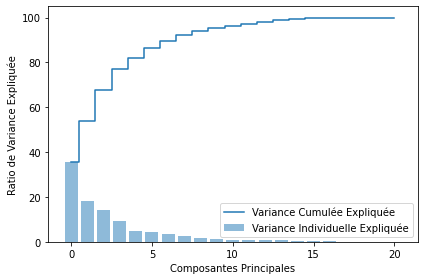

In [54]:
# Plotting the Summary Plot of the Cumulative Variance Explained:

plt.bar(range(21), exp_var, alpha=0.50, align = 'center', label='Variance Individuelle Expliquée')
plt.step(range(21), tot_var, where ='mid', label='Variance Cumulée Expliquée')
plt.ylabel('Ratio de Variance Expliquée')
plt.xlabel('Composantes Principales')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('pca.png')
plt.show()

### PCA using sklearn:

As we don't know how many components we want hence will start with all the 21 features and will see post fitting the model the eigen values i.e. the explained variance captured by each of the new components (or eigen vectors).

In [55]:
pca_model = PCA(n_components = 21)
X_PCA = pca_model.fit_transform(concat_df)

In [56]:
X_PCA.shape

(48000, 21)

In [57]:
# Cumulative Variance explained:
pca_var = pca_model.explained_variance_ratio_
np.cumsum(pca_var)

array([0.35505475, 0.53712498, 0.6773999 , 0.77195956, 0.81875108,
       0.86395981, 0.89730693, 0.92150349, 0.93991415, 0.95330026,
       0.96327566, 0.972724  , 0.98126497, 0.98843567, 0.99329011,
       0.99682934, 0.99928066, 0.99971442, 0.99986749, 0.99998226,
       1.        ])

In [58]:
# Cumulative Variance explains
var1 = np.cumsum(np.round(pca_model.explained_variance_ratio_, decimals=6)*100)
var1

array([ 35.5055,  53.7125,  67.74  ,  77.196 ,  81.8752,  86.3961,
        89.7308,  92.1505,  93.9916,  95.3302,  96.3277,  97.2725,
        98.1266,  98.8437,  99.3291,  99.683 ,  99.9281,  99.9715,
        99.9868,  99.9983, 100.0001])

In [59]:
# Summary table showing the Eigen Vectors, Eigen Values and the variance explained by each of the component(eigenvector)

vec_val = pd.DataFrame({'Eigen_Values':pca_model.explained_variance_, 'Cumulative_Variance':var1}, 
                       index=range(1,22)).round(2)
vec_val

Eigen_Values  Cumulative_Variance
1           6.24                35.51
2           3.20                53.71
3           2.47                67.74
4           1.66                77.20
5           0.82                81.88
6           0.79                86.40
7           0.59                89.73
8           0.43                92.15
9           0.32                93.99
10          0.24                95.33
11          0.18                96.33
12          0.17                97.27
13          0.15                98.13
14          0.13                98.84
15          0.09                99.33
16          0.06                99.68
17          0.04                99.93
18          0.01                99.97
19          0.00                99.99
20          0.00               100.00
21          0.00               100.00

### Conclusion:

By considering the 7 dimensions out of the 21 variables we are losing only about 10% of the variation (information) of the data.

The 7 eigenvectors or principal components are as follows:

In [60]:
### PCA with 7 components:

PCA_7 = PCA(n_components=7)
X_PCA_7 = PCA_7.fit_transform(concat_df)


In [61]:
PC = pd.DataFrame(X_PCA_7, columns=['PC1 PC2 PC3 PC4 PC5 PC6 PC7'.split()])
PC

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0     -1.100810 -0.201878 -0.889492  0.113093 -0.002146  0.112760 -0.130071
1     -1.378024  0.898140 -0.501783  0.053293  0.943705  0.732766 -0.850237
2     -1.421539 -0.301125  0.492301  0.008301 -0.419261 -0.097191 -0.184941
3     -1.104898 -0.715394  1.368197 -0.012492  0.098898  0.098261 -0.581704
4     -2.328625  0.239586  1.230903 -0.073024  0.644674  0.140759 -1.329068
...         ...       ...       ...       ...       ...       ...       ...
47995 -0.172715  3.349249  0.181142 -0.701946  0.479027  2.175830  0.271064
47996 -2.104837  0.190016 -0.614759  0.171508  0.691743 -0.105897 -0.130564
47997 -1.614004  0.004031  0.227405  0.452614  0.097612 -0.094135 -0.509809
47998 -2.978739  0.633402 -0.675822  0.344749  1.447766 -0.485206  1.131365
47999 -3.071525  0.646899 -0.567160  0.340392  1.654678 -0.464228  1.015999

[48000 rows x 7 columns]

Following are the Principal components taking all the 17 variables:

In [62]:
# Taking out the list of columns:

list_cols = concat_df.columns

In [63]:
PC_with_all_variables = pd.DataFrame(PCA_7.components_.T, columns = ['PC_'+str(i) for i in range(1,8)], index = list_cols)
PC_with_all_variables

PC_1      PC_2      PC_3      PC_4      PC_5  \
NS                    0.333910 -0.273301 -0.009397  0.007907  0.168531   
NS_CAPSULES           0.307399 -0.322333 -0.038494 -0.019069  0.157215   
NS_MACHINES           0.228509  0.310251  0.170025 -0.019727  0.202917   
NS_After              0.141158  0.149256  0.097981  0.642713  0.022494   
Allowances           -0.274605 -0.171995 -0.050311  0.162031 -0.154856   
TAX_AMNT              0.363639 -0.154442  0.048231  0.060170  0.193440   
nORD                  0.215233 -0.293723  0.360588 -0.013322  0.091322   
AVG_NS_p_ORD          0.262581 -0.075539 -0.455364  0.006830 -0.098498   
AVG_CAPSULES_p_ORD    0.221208 -0.165738 -0.473828  0.009506 -0.089373   
AVG_MACHINES_p_ORD    0.176095  0.420955  0.074878 -0.188713  0.046617   
AVG_After_p_ORD       0.112261  0.166252  0.032277  0.657931 -0.061338   
AVG_Allowances_p_ORD -0.208670 -0.313044  0.049094  0.253417  0.011560   
AVG_TAX               0.304475  0.120348 -0.347429 -0.001501 -0.082080   
AVG_UnP               0.212472  0.403706  0.042115 -0.047856 -0.054238   
var_PCAT1             0.211950 -0.060553  0.141511 -0.015138 -0.744928   
avg_time_diff         0.168684 -0.102939  0.312890 -0.104341 -0.453845   
avg_ord_pM            0.217589 -0.142166  0.374912 -0.057107  0.145559   
nM_PLACED             0.064434  0.121847  0.056014 -0.079213 -0.035358   
nM_CANCELLED          0.000241  0.000883  0.002237 -0.000863 -0.000791   
HORECA                0.011839 -0.019170  0.001436 -0.016167  0.136703   
Master                0.001021 -0.000623  0.001338 -0.001674  0.001812   

                          PC_6      PC_7  
NS                   -0.013556  0.043396  
NS_CAPSULES          -0.040337  0.002126  
NS_MACHINES           0.216922  0.237095  
NS_After             -0.087586 -0.050578  
Allowances            0.615263  0.003026  
TAX_AMNT              0.040566  0.109109  
nORD                  0.013555  0.040231  
AVG_NS_p_ORD          0.108093 -0.067962  
AVG_CAPSULES_p_ORD    0.037351 -0.085333  
AVG_MACHINES_p_ORD    0.345796 -0.000504  
AVG_After_p_ORD      -0.112884 -0.128446  
AVG_Allowances_p_ORD  0.503188  0.183872  
AVG_TAX               0.230188 -0.046390  
AVG_UnP               0.229619 -0.006550  
var_PCAT1            -0.119098  0.559243  
avg_time_diff         0.106723 -0.725515  
avg_ord_pM            0.181284  0.003367  
nM_PLACED            -0.002412  0.004909  
nM_CANCELLED          0.001330  0.000583  
HORECA                0.018183 -0.149078  
Master                0.001388 -0.004443

In [64]:
# Exporting the output:
PC_with_all_variables.to_csv('PC_with_all_variables.csv')

In [65]:
# Variance explained by each of the Component:

pd.Series(PCA_7.explained_variance_ratio_*100, index = ['PC_' + str(i) for i in range(1,8)])

PC_1    35.505475
PC_2    18.207023
PC_3    14.027492
PC_4     9.455966
PC_5     4.679152
PC_6     4.520873
PC_7     3.334712
dtype: float64

### Variable Reduction (Factor Analysis)

Using factor loadings finding out which of the variables have the maximum contirbution in each of the components.

Loadings are the correlation between the original variables and the unit-scaled components. We find the loadings by:

Loadings=Eigenvectors * sqrt(Eigenvalues)

This results in a loading matrix. 

In [66]:
Loadings = pd.DataFrame((pca_model.components_.T * np.sqrt(pca_model.explained_variance_)).T, index= list_cols,columns=['PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10 PC11 PC12 PC13 PC14 PC15 PC16 PC17 PC18 PC19 PC20 PC21'.split()])

In [67]:
Loadings.round(2)

PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  \
NS                    0.83  0.77  0.57  0.35 -0.69  0.91  0.54  0.66  0.55   
NS_CAPSULES          -0.49 -0.58  0.56  0.27 -0.31 -0.28 -0.53 -0.14 -0.30   
NS_MACHINES          -0.01 -0.06  0.27  0.15 -0.08  0.08  0.57 -0.72 -0.74   
NS_After              0.01 -0.02 -0.03  0.83  0.21  0.08 -0.02  0.01  0.01   
Allowances            0.15  0.14  0.18  0.02 -0.14  0.18  0.08 -0.09 -0.08   
TAX_AMNT             -0.01 -0.04  0.19 -0.08  0.55  0.04  0.01  0.10  0.03   
nORD                  0.03  0.00  0.18 -0.04  0.00  0.08  0.03 -0.05 -0.07   
AVG_NS_p_ORD         -0.10 -0.06 -0.30 -0.04  0.07 -0.16  0.12  0.06  0.05   
AVG_CAPSULES_p_ORD   -0.16 -0.19  0.29  0.03 -0.10 -0.08  0.00  0.12  0.16   
AVG_MACHINES_p_ORD    0.01  0.01 -0.01 -0.01  0.00  0.01 -0.01 -0.01 -0.01   
AVG_After_p_ORD       0.01  0.01  0.00 -0.07 -0.14  0.01 -0.13  0.00  0.01   
AVG_Allowances_p_ORD -0.01 -0.02 -0.05  0.28  0.02  0.00 -0.01  0.01  0.03   
AVG_TAX               0.00  0.01  0.02  0.01  0.10  0.00  0.07  0.00 -0.00   
AVG_UnP               0.06  0.07 -0.03  0.02  0.04  0.05 -0.27 -0.04 -0.04   
var_PCAT1            -0.02 -0.00 -0.10  0.04 -0.14 -0.04  0.03  0.01 -0.01   
avg_time_diff        -0.00 -0.02  0.00 -0.01 -0.02  0.02 -0.01 -0.01 -0.04   
avg_ord_pM            0.01  0.07  0.03  0.00  0.00 -0.08 -0.00  0.01  0.08   
nM_PLACED            -0.00 -0.04 -0.02 -0.01 -0.00  0.05 -0.00  0.01  0.02   
nM_CANCELLED         -0.00  0.00  0.00  0.00 -0.00 -0.00 -0.00 -0.00 -0.00   
HORECA                0.02 -0.01  0.00  0.00  0.00 -0.01  0.00  0.03 -0.02   
Master               -0.01  0.01 -0.00 -0.00  0.00  0.00 -0.00  0.01 -0.00   

                      PC10  ...  PC12  PC13  PC14  PC15  PC16  PC17  PC18  \
NS                    0.44  ... -0.52  0.76  0.53  0.53  0.42  0.54  0.16   
NS_CAPSULES           0.75  ... -0.56  0.22  0.72 -0.11 -0.18 -0.25  0.22   
NS_MACHINES           0.12  ...  0.08 -0.55  0.07  0.22  0.49  0.59  0.09   
NS_After             -0.24  ...  0.33 -0.00 -0.06 -0.02 -0.13 -0.07 -0.10   
Allowances            0.04  ...  0.01 -0.07 -0.05 -0.68 -0.41  0.13 -0.03   
TAX_AMNT              0.31  ...  0.45  0.21  0.20 -0.11  0.10  0.16 -0.00   
nORD                 -0.00  ...  0.14 -0.04 -0.01  0.43 -0.56  0.00  0.00   
AVG_NS_p_ORD          0.01  ... -0.16  0.07  0.12  0.00 -0.19  0.42 -0.00   
AVG_CAPSULES_p_ORD   -0.11  ...  0.03  0.02 -0.24  0.00  0.05  0.20 -0.01   
AVG_MACHINES_p_ORD    0.00  ...  0.00  0.00  0.01  0.00 -0.00 -0.01  0.00   
AVG_After_p_ORD      -0.11  ...  0.14 -0.02  0.13 -0.06  0.04  0.09  0.01   
AVG_Allowances_p_ORD -0.03  ... -0.03 -0.03  0.07 -0.01  0.00  0.03 -0.01   
AVG_TAX               0.11  ... -0.12  0.02 -0.17 -0.04 -0.00 -0.02 -0.01   
AVG_UnP               0.06  ... -0.04 -0.02 -0.11  0.04  0.01  0.13  0.01   
var_PCAT1             0.15  ...  0.13  0.05 -0.08  0.01 -0.00 -0.01  0.00   
avg_time_diff        -0.00  ... -0.01  0.04  0.02  0.01  0.01  0.01 -0.24   
avg_ord_pM            0.06  ...  0.00 -0.13  0.03  0.01 -0.00 -0.00 -0.05   
nM_PLACED             0.02  ...  0.00 -0.04  0.00 -0.00  0.00 -0.00 -0.00   
nM_CANCELLED          0.00  ... -0.00  0.00 -0.00  0.00 -0.00 -0.00 -0.00   
HORECA               -0.00  ... -0.00 -0.01 -0.00 -0.00  0.00  0.00  0.00   
Master               -0.00  ... -0.00 -0.00  0.00  0.00  0.00  0.00  0.00   

                      PC19  PC20  PC21  
NS                    0.00  0.03  0.00  
NS_CAPSULES           0.00 -0.03 -0.00  
NS_MACHINES           0.00  0.00  0.00  
NS_After             -0.00 -0.02 -0.00  
Allowances           -0.00  0.12  0.00  
TAX_AMNT              0.00  0.02  0.00  
nORD                  0.00 -0.11 -0.00  
AVG_NS_p_ORD          0.00  0.02  0.00  
AVG_CAPSULES_p_ORD   -0.00  0.05  0.03  
AVG_MACHINES_p_ORD    0.00 -0.00  0.48  
AVG_After_p_ORD       0.01 -0.27 -0.00  
AVG_Allowances_p_ORD  0.00 -0.07  0.01  
AVG_TAX              -0.01 -0.27  0.00  
AVG_UnP              -0.01  0.04 -0.0

In [68]:
# Exporting the output:
Loadings.to_csv('Loadings1.csv')

### Clustering

Performing Clustering on the 7 components which were found after reducing the dimensionality using PCA.

Finding the optimal clusters using:

1) K-Means\
2) Hierarchical Clustering (Agglomerative)\
3) Silhouette Score\
4) Plotting Elbow Method\
5) Plotting Dendrogram\
6) Finding the Segment Distributuion for each cluster\
7) Performing Profiling

I took out some of the technical Steps due to insufficient RAM Capacity
Analysis on scaled data also pointed to 5-6 Clusters

### Step 2: Finding the Optimal clusters using K-Means, (Silhouette Coefficient Score for both K-Means and Agglomerative Clustering- not executed here due to insufficient RAM Capacticy)

In [69]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from scipy.spatial.distance import pdist

In [70]:
# Step 2: Finding the Optimal clusters using KMeans, Silhouette Coefficient Score for both KMeans and Agglomerative Clustering

wcss = []
sil_kmeans = []
sil_agc = []

for i in range(3,9):
    
    # K-Means Clustering:
    kmeans = KMeans(n_clusters = i, n_init = 100, init='k-means++', random_state = 0)
    kmeans.fit(X_PCA_7)
    
     # Inertia and Silhouette Score for Clusters using K-Means:
    in_km = kmeans.inertia_
    wcss.append(in_km)
#    sil_km = silhouette_score(X_PCA_7, kmeans.labels_)
#    sil_kmeans.append(sil_km)
    
    # Agglomerative Clusters and its Silhouette Score
#    agc = AgglomerativeClustering(n_clusters = i, affinity = 'cityblock', linkage = 'average')
#    agc.fit(X_PCA_7)
#    sil_ag = silhouette_score(X_PCA_7, agc.labels_)
#    sil_agc.append(sil_ag)
    
    print('Number of clusters:', i)
    print('KMeans Inertia', in_km)
#    print('Silhouette Score for KMeans:', sil_km)
#    print('Silhouette Score for AGC(HCA):', sil_ag)
    print()

Number of clusters: 3
KMeans Inertia 477806.7459166769

Number of clusters: 4
KMeans Inertia 414957.81595884333

Number of clusters: 5
KMeans Inertia 362845.6156816448

Number of clusters: 6
KMeans Inertia 320244.5284988864

Number of clusters: 7
KMeans Inertia 288912.82013963116

Number of clusters: 8
KMeans Inertia 260021.69816304496



In [71]:
#from yellowbrick.cluster import SilhouetteVisualizer

In [72]:
# plt.style.use('seaborn-paper')
# fig, axs = plt.subplots(2, 3, figsize=(20, 15))
# axs = axs.reshape(6)
# for i, k in enumerate(range(3, 9)):
#     ax = axs[i]
#     sil = SilhouetteVisualizer(KMeans(n_clusters = k, n_init = 100, init='k-means++', random_state = 0), ax=ax)
#     sil.fit(X_PCA_7)
#     sil.finalize()

### 3. Elbow Method

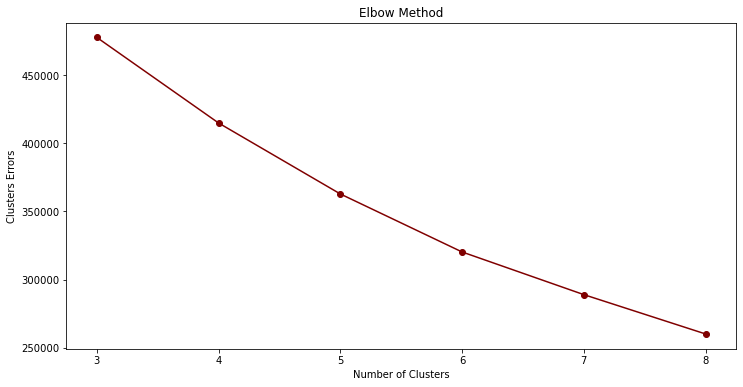

In [73]:
# Plotting graph of Elbow Method 

plt.figure(figsize=(12,6))
plt.plot(range(3,9), wcss, c ='#800000', marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Clusters Errors')
plt.show()

# Inertia or Sum of Squared Errors within the Clusters is also known as the Cluster Errors

# CLuster error will decrease after some Clusters but 

### Inference of Elbow Method:

The sum of squared distances of each data point within a cluster from its respective centroid is called the inertia. The K at which the inertia stops to drop significantly (using the above elbow method) is the best K.

In [74]:
# Plotting the Silhouette Score for the clusters found from K-Means and Agglomerative Clustering

# plt.figure(figsize=(12,6))
# plt.plot(range(3,9), sil_kmeans, marker='s', c='purple')
# plt.title('Silhouette Scores for K-Means Clustering')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette Score')
# plt.show()

In [75]:
# Plotting the Silhouette Score for the clusters found from K-Means and Agglomerative Clustering

# plt.figure(figsize=(12,6))
# plt.plot(range(3,9), sil_agc, marker='s', c='g')
# plt.title('Silhouette Scores for Agglomerative Clustering')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette Score')
# plt.show()

### 4. Dendrogram

In [76]:
# Plotting Dendrogram

# Z= linkage(concat_df, method = 'average', metric = 'euclidean')
# plt.figure(figsize=(14,10))
# plt.title('Agglomerative Hierarchical Clustering Dendrogram')
# plt.xlabel('Sample Index')
# plt.ylabel('Distance')
# dendrogram(Z, leaf_rotation=90, leaf_font_size=8, truncate_mode='level', p =9)
# plt.tight_layout()
# plt.show()



### Conclusion:

We cannot really determine a clear cutoff from the Elbow method. We will thus do the CLustering for k(3,8) and determine via profiling the best option for k.


### Applying Clustering and visualizing the spread of the data

Scatter plot for Principal Components 0 and 1


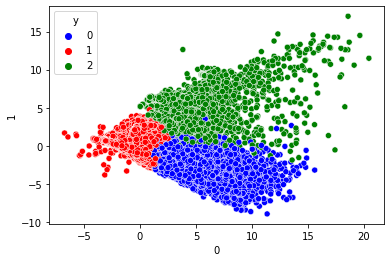

Scatter plot for Principal Components 1 and 2


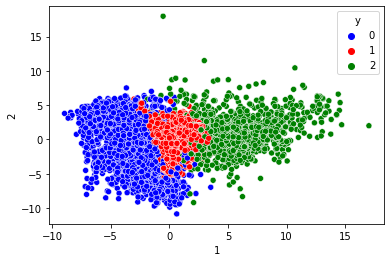

Scatter plot for Principal Components 2 and 3


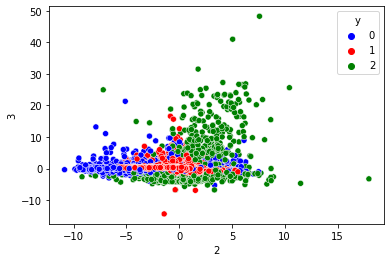

Scatter plot for Principal Components 3 and 4


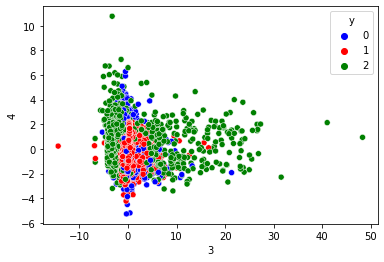

Scatter plot for Principal Components 4 and 5


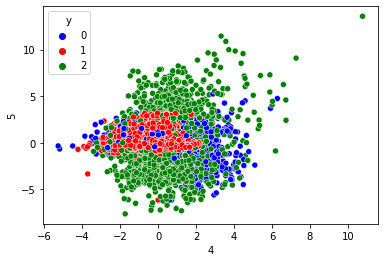

Scatter plot for Principal Components 5 and 6


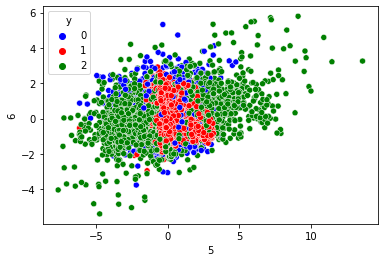

In [77]:
### Applying Clustering and visualizing the spread of the data (finding out if the data points have been clustered correctly through visualization)

#K-Means Clusters:   For K= 3
kmeans = KMeans(n_clusters = 3, n_init = 100, init='k-means++', random_state = 0)
kmeans.fit(X_PCA_7)

# Taking into each dataframes
df_pca = pd.DataFrame(X_PCA_7)
y_lab = pd.Series(kmeans.labels_, name = 'y') # labels for clusters

#concatenating the dataframe:
df_final = pd.concat([df_pca, y_lab], axis = 1)

# As there are 7 dimensions, hence we need to plot for each of the different pairs to visualize the spread of the data:

for i in range(6):
    print('Scatter plot for Principal Components', i, 'and', i+1)
    sns.scatterplot(df_pca[i], df_pca[i+1], hue = df_final['y'], palette = ['blue', 'red', 'green'])
    plt.show()

Scatter plot for Principal Components 0 and 1


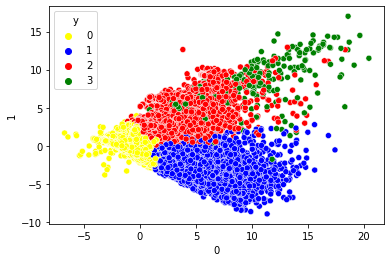

Scatter plot for Principal Components 1 and 2


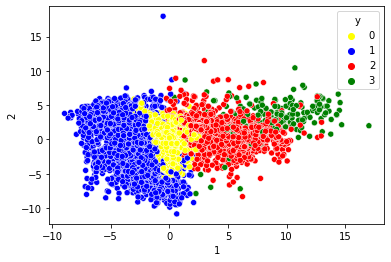

Scatter plot for Principal Components 2 and 3


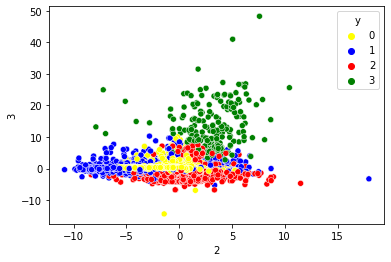

Scatter plot for Principal Components 3 and 4


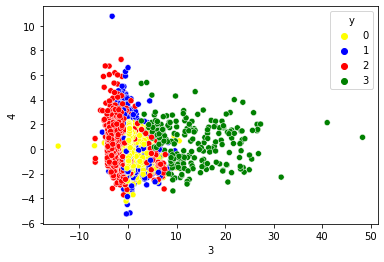

Scatter plot for Principal Components 4 and 5


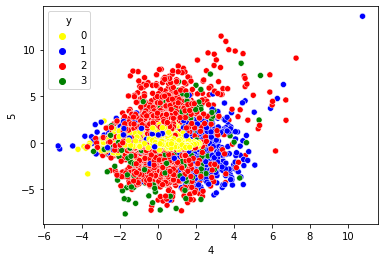

Scatter plot for Principal Components 5 and 6


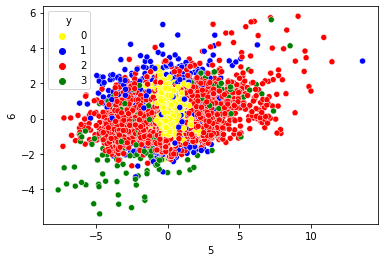

In [78]:
### Applying Clustering and visualizing the spread of the data (finding out if the data points have been clustered correctly through visualization)

#K-Means Clusters:   For K= 4
kmeans = KMeans(n_clusters = 4, n_init = 100, init='k-means++', random_state = 0)
kmeans.fit(X_PCA_7)

# Taking into each dataframes
df_pca = pd.DataFrame(X_PCA_7)
y_lab = pd.Series(kmeans.labels_, name = 'y') # labels for clusters

#concatenating the dataframe:
df_final = pd.concat([df_pca, y_lab], axis = 1)

# As there are 7 dimensions, hence we need to plot for each of the different pairs to visualize the spread of the data:

for i in range(6):
    print('Scatter plot for Principal Components', i, 'and', i+1)
    sns.scatterplot(df_pca[i], df_pca[i+1], hue = df_final['y'], palette = ['yellow', 'blue', 'red', 'green'])
    plt.show()

Scatter plot for Principal Components 0 and 1


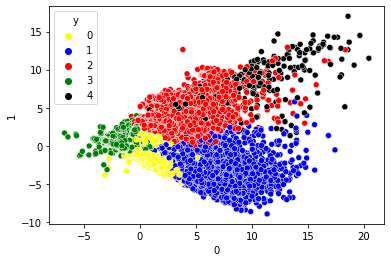

Scatter plot for Principal Components 1 and 2


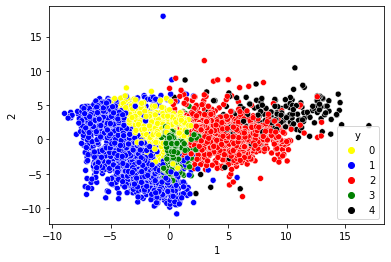

Scatter plot for Principal Components 2 and 3


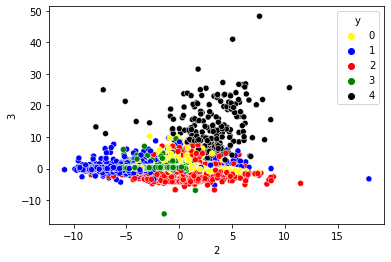

Scatter plot for Principal Components 3 and 4


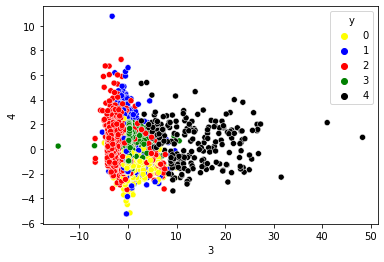

Scatter plot for Principal Components 4 and 5


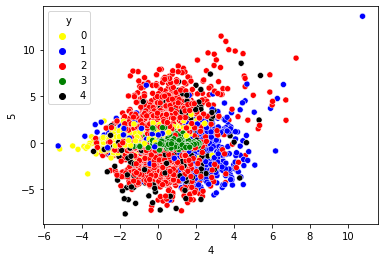

Scatter plot for Principal Components 5 and 6


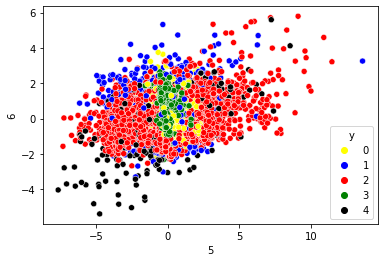

In [79]:
### Applying Clustering and visualizing the spread of the data (finding out if the data points have been clustered correctly through visualization)

#K-Means Clusters:   For K= 5
kmeans = KMeans(n_clusters = 5, n_init = 100, init='k-means++', random_state = 0)
kmeans.fit(X_PCA_7)

# Taking into each dataframes
df_pca = pd.DataFrame(X_PCA_7)
y_lab = pd.Series(kmeans.labels_, name = 'y') # labels for clusters

#concatenating the dataframe:
df_final = pd.concat([df_pca, y_lab], axis = 1)

# As there are 7 dimensions, hence we need to plot for each of the different pairs to visualize the spread of the data:

for i in range(6):
    print('Scatter plot for Principal Components', i, 'and', i+1)
    sns.scatterplot(df_pca[i], df_pca[i+1], hue = df_final['y'], palette = ['yellow', 'blue', 'red', 'green','black'])
    plt.show()

### 5. Segment Distribution

Segment distribution gives the percentage of values in each Segment

In [80]:
# Step 1: Making K-Means Cluster and Labels for finding out the distribution of Segments and then performing Profiling

# K = 3

km_3 = KMeans(n_clusters = 3, n_init = 100, init='k-means++', random_state = 0)             
KM_3 = km_3.fit(X_PCA_7)

In [81]:
# Labels of Cluster 3

KM_3.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [82]:
# Centroids for Cluster 3:

KM_3.cluster_centers_

array([[ 3.63735605, -2.10593061, -0.713213  , -0.02245878,  0.08355382,
         0.06892847,  0.04062658],
       [-0.95717555,  0.0440826 ,  0.08283714,  0.05187968, -0.03846453,
         0.01141472, -0.01287027],
       [ 4.88140891,  4.62377813,  0.57413315, -0.70152897,  0.35278176,
        -0.33912485,  0.08635095]])

### Taking Clsuters for K = 4,5, 6,7,8

In [83]:
KM_4 = KMeans(n_clusters = 4, n_init = 100, init='k-means++', random_state = 0).fit(X_PCA_7)
KM_5 = KMeans(n_clusters = 5, n_init = 100, init='k-means++', random_state = 0).fit(X_PCA_7)
KM_6 = KMeans(n_clusters = 6, n_init = 100, init='k-means++', random_state = 0).fit(X_PCA_7)
KM_7 = KMeans(n_clusters = 7, n_init = 100, init='k-means++', random_state = 0).fit(X_PCA_7)
KM_8 = KMeans(n_clusters = 8, n_init = 100, init='k-means++', random_state = 0).fit(X_PCA_7)

In [84]:
# Appending the Cluster labels to the Original Data: (not to Standardized data)

original_df['cluster_3'] = KM_3.labels_
original_df['cluster_4'] = KM_4.labels_
original_df['cluster_5'] = KM_5.labels_
original_df['cluster_6'] = KM_6.labels_
original_df['cluster_7'] = KM_7.labels_
original_df['cluster_8'] = KM_8.labels_

In [85]:
# the new data set has Original variables + the Cluster Labels from each of the clusters got from K-Means

original_df.shape

(48000, 27)

In [86]:
original_df.to_csv('df_clustered.csv')

In [87]:
# Finding the Segment Distribution for cluster K = 3 :

pd.Series.sort_index(original_df.cluster_3.value_counts())/sum(original_df.cluster_3.value_counts())

0    0.138250
1    0.806479
2    0.055271
Name: cluster_3, dtype: float64

In [88]:
# Segment Distribution for cluster K = 4 :

pd.Series.sort_index(original_df.cluster_4.value_counts())/sum(original_df.cluster_4.value_counts())

0    0.767750
1    0.131375
2    0.096437
3    0.004437
Name: cluster_4, dtype: float64

In [89]:
# Segment Distribution for cluster K = 5 :

pd.Series.sort_index(original_df.cluster_5.value_counts())/sum(original_df.cluster_5.value_counts())

0    0.366375
1    0.078458
2    0.092292
3    0.458458
4    0.004417
Name: cluster_5, dtype: float64

In [90]:
# Segment Distribution for cluster K = 6 :

pd.Series.sort_index(original_df.cluster_6.value_counts())/sum(original_df.cluster_6.value_counts())

0    0.087271
1    0.407958
2    0.084937
3    0.368729
4    0.046708
5    0.004396
Name: cluster_6, dtype: float64

In [91]:
# Segment Distribution for cluster K = 7 :

pd.Series.sort_index(original_df.cluster_7.value_counts())/sum(original_df.cluster_7.value_counts())

0    0.440667
1    0.038104
2    0.004229
3    0.041021
4    0.107063
5    0.082208
6    0.286708
Name: cluster_7, dtype: float64

In [92]:
# Segment Distribution for cluster K = 8 :

pd.Series.sort_index(original_df.cluster_8.value_counts())/sum(original_df.cluster_8.value_counts())

0    0.441229
1    0.033250
2    0.108938
3    0.004229
4    0.139271
5    0.038854
6    0.076729
7    0.157500
Name: cluster_8, dtype: float64

### 6. Profiling

The goal of Profiling is to be able to differentiate between the groups with the proper distinction that means each group has some unique characteristics about it and then that cluster is the ideal solution to segment the values.

Steps to do Profiling are:

1) Find the count of each segment (value_counts) ----> that gives how many observations or records are present in each segment\
2) For each of the variable: find the overall average and the individual segment-wise average\
3) Perform the above two steps for each K value to find the best profiling

#### Step 1 of Profiling:
    
    Finding how many observations or records are present in each segment

In [93]:
# Step 1a: Get the total size of the cluster:
original_df.cluster_3.size

# Step 1b: Get the break up of the values in each segment:
# which gives how many observations are there in each of the respective segment:

original_df.cluster_3.value_counts()

1    38711
0     6636
2     2653
Name: cluster_3, dtype: int64

In [94]:
# by using the Sort Index provides:
# the value counts based on the Segment Label (0,1,2 depending upon the K-value) in the index
# and not based on the highest value within the segments

pd.Series.sort_index(original_df.cluster_3.value_counts())

0     6636
1    38711
2     2653
Name: cluster_3, dtype: int64

Repeat the above two steps for other clusters K = 4 to K = 8 and then combine all into a single array.

In [95]:
# combining the size for each cluster K value into one single array:

size=pd.concat([pd.Series(original_df.cluster_3.size), pd.Series.sort_index(original_df.cluster_3.value_counts()), pd.Series.sort_index(original_df.cluster_4.value_counts()),
           pd.Series.sort_index(original_df.cluster_5.value_counts()), pd.Series.sort_index(original_df.cluster_6.value_counts()),
           pd.Series.sort_index(original_df.cluster_7.value_counts()), pd.Series.sort_index(original_df.cluster_8.value_counts())])

In [96]:
# Gives the size of Segments for each of the Clusters :

#size

In [97]:
# Segment Size:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])

# Segment Distribtuion % wise:
Seg_Pct = pd.DataFrame(size/original_df.cluster_3.size, columns=['Seg_Pct'])

In [98]:
# Taking Transpose of Segment Percentage :
Seg_Pct.T

0        0         1         2        0         1         2  \
Seg_Pct  1.0  0.13825  0.806479  0.055271  0.76775  0.131375  0.096437   

                3         0         1  ...         5         6         0  \
Seg_Pct  0.004437  0.366375  0.078458  ...  0.082208  0.286708  0.441229   

               1         2         3         4         5         6       7  
Seg_Pct  0.03325  0.108938  0.004229  0.139271  0.038854  0.076729  0.1575  

[1 rows x 34 columns]

In [99]:
# Concatenating the Segment Size and Segment Percentage:
pd.concat([Seg_size.T, Seg_Pct.T], axis=0)

0           0             1            2            0  \
Seg_size  48000.0  6636.00000  38711.000000  2653.000000  36852.00000   
Seg_Pct       1.0     0.13825      0.806479     0.055271      0.76775   

                    1            2           3             0            1  \
Seg_size  6306.000000  4629.000000  213.000000  17586.000000  3766.000000   
Seg_Pct      0.131375     0.096437    0.004437      0.366375     0.078458   

          ...            5             6             0           1  \
Seg_size  ...  3946.000000  13762.000000  21179.000000  1596.00000   
Seg_Pct   ...     0.082208      0.286708      0.441229     0.03325   

                    2           3            4            5            6  \
Seg_size  5229.000000  203.000000  6685.000000  1865.000000  3683.000000   
Seg_Pct      0.108938    0.004229     0.139271     0.038854     0.076729   

                  7  
Seg_size  7560.0000  
Seg_Pct      0.1575  

[2 rows x 34 columns]

For each of the variable :  find the overall average and the inidividual segment wise average

#### Step 2 of Profiling:

      For each of the variable :  find the overall average and the inidividual segment wise average
      
A good indication of the distribution of data is the mean value, hence will find the average value for each variable and for each cluster.

In [100]:
# Overall each variables wise Avg:
means = original_df.apply(np.mean).T
means.to_csv('total_means.csv')

In [101]:
# Grouping-by over each cluster to find the Segment wise average for each variable
original_df.groupby('cluster_3').apply(np.mean).T

cluster_3                       0            1            2
NS                    5946.977241  1003.498509  2633.351060
NS_CAPSULES           5553.433452   910.464563  1643.764755
NS_MACHINES             72.546688    33.336037   774.530388
NS_After                23.246942     6.002667   109.834127
Allowances            -147.810708   -19.248861  -475.173100
TAX_AMNT               367.707978    65.744495   283.200690
nORD                    11.922544     4.716282     6.080663
AVG_NS_p_ORD           656.618712   229.432789   454.225336
AVG_CAPSULES_p_ORD     618.696465   206.528151   269.329137
AVG_MACHINES_p_ORD       5.424004     9.267191   153.812537
AVG_After_p_ORD          2.726767     1.472300    13.345630
AVG_Allowances_p_ORD   -15.966415    -5.160628   -94.284099
AVG_TAX                 39.868025    15.279262    50.929139
AVG_UnP                 28.242345    19.441430   177.371809
nM_PLACED                0.154913     0.140141     0.957784
nM_CANCELLED             0.001808     0.002687     0.010554
HORECA                   0.327908     0.231769     0.296268
var_PCAT1               11.293701     7.335228    11.016962
avg_time_diff            0.861221     0.680593     0.808918
avg_ord_pM               1.054121     0.498921     0.941957
Master                   0.381706     0.379995     0.362608
cluster_3                0.000000     1.000000     2.000000
cluster_4                0.970766     0.112139     2.042970
cluster_5                0.592375     1.807367     2.109310
cluster_6                2.876884     1.814316     0.577083
cluster_7                4.703285     2.455607     1.782887
cluster_8                5.205244     2.016300     4.203166

In [102]:
# Concatinating the above two averages:

Profiling_output = pd.concat([original_df.apply(lambda x: x.mean()).T, 
                original_df.groupby('cluster_3').apply(lambda x: x.mean()).T, 
                original_df.groupby('cluster_4').apply(lambda x: x.mean()).T,
                original_df.groupby('cluster_5').apply(lambda x: x.mean()).T, 
                original_df.groupby('cluster_6').apply(lambda x: x.mean()).T,
                original_df.groupby('cluster_7').apply(lambda x: x.mean()).T, 
                original_df.groupby('cluster_8').apply(lambda x: x.mean()).T], axis=1)


In [103]:
Profiling_output

0            0            1            2  \
NS                    1777.017752  5946.977241  1003.498509  2633.351060   
NS_CAPSULES           1592.885125  5553.433452   910.464563  1643.764755   
NS_MACHINES             79.723339    72.546688    33.336037   774.530388   
NS_After                14.125540    23.246942     6.002667   109.834127   
Allowances             -62.221849  -147.810708   -19.248861  -475.173100   
TAX_AMNT               119.509932   367.707978    65.744495   283.200690   
nORD                     5.787958    11.922544     4.716282     6.080663   
AVG_NS_p_ORD           300.915714   656.618712   229.432789   454.225336   
AVG_CAPSULES_p_ORD     266.981483   618.696465   206.528151   269.329137   
AVG_MACHINES_p_ORD      16.725012     5.424004     9.267191   153.812537   
AVG_After_p_ORD          2.301979     2.726767     1.472300    13.345630   
AVG_Allowances_p_ORD   -11.580457   -15.966415    -5.160628   -94.284099   
AVG_TAX                 20.649057    39.868025    15.279262    50.929139   
AVG_UnP                 29.387100    28.242345    19.441430   177.371809   
nM_PLACED                0.187375     0.154913     0.140141     0.957784   
nM_CANCELLED             0.003000     0.001808     0.002687     0.010554   
HORECA                   0.248625     0.327908     0.231769     0.296268   
var_PCAT1                8.085979    11.293701     7.335228    11.016962   
avg_time_diff            0.712658     0.861221     0.680593     0.808918   
avg_ord_pM               0.600164     1.054121     0.498921     0.941957   
Master                   0.379271     0.381706     0.379995     0.362608   
cluster_3                0.917021     0.000000     1.000000     2.000000   
cluster_4                0.337562     0.970766     0.112139     2.042970   
cluster_5                1.656083     0.592375     1.807367     2.109310   
cluster_6                1.892833     2.876884     1.814316     0.577083   
cluster_7                2.729167     4.703285     2.455607     1.782887   
cluster_8                2.578042     5.205244     2.016300     4.203166   

                                0            1            2            3  \
NS                    1038.946498  6159.549347  1537.220873  4937.474961   
NS_CAPSULES            956.197875  5742.987303   985.159814  2089.667517   
NS_MACHINES             20.675619    83.161350   480.203350  1490.636479   
NS_After                 6.274262    23.745975     9.253647  1193.565915   
Allowances             -14.389085  -159.794583  -289.623973  -507.268498   
TAX_AMNT                66.060389   382.087957   161.862602   672.819834   
nORD                     4.867253    12.106089     4.323612     9.854460   
AVG_NS_p_ORD           229.634772   670.914975   353.992625   525.971643   
AVG_CAPSULES_p_ORD     211.586174   631.865323   213.087451   219.779068   
AVG_MACHINES_p_ORD       4.172241     5.837094   125.393290   149.252948   
AVG_After_p_ORD          1.510443     2.707596     1.679147   140.775902   
AVG_Allowances_p_ORD    -3.102037   -16.873747   -69.645595   -59.860859   
AVG_TAX                 14.565020    40.781604    39.286325    72.203875   
AVG_UnP                 14.352498    29.295469   137.333416   287.365923   
nM_PLACED                0.091637     0.157469     0.957658     0.896714   
nM_CANCELLED             0.002551     0.001903     0.008209     0.000000   
HORECA                   0.235238     0.327149     0.252970     0.145540   
var_PCAT1                7.291246    11.375833     9.662130    13.934272   
avg_time_diff            0.668441     0.862362     0.851419     0.915093   
avg_ord_pM               0.490235     1.070835     0.798771     1.368730   
Master                   0.378650     0.383603     0.378051     0.384977   
cluster_3                0.991697     0.027276     1.488010     1.929577   
cluster_4                0.000000     1.000000     2.000000     3.000000   
cluster_5                1.792114     0.609578     1.891553     3.985915   
clu

In [104]:
# Combining the outputs from steps 1 and 2: 
# Concatenating the segment size, segment distribution, the overall averages, and the individual segment-wise average 

Profiling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, Profiling_output], axis=0)

# Adding column names

Profiling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]

In [105]:
Profiling_output_final

Overall        KM3_1         KM3_2        KM3_3  \
Seg_size              48000.000000  6636.000000  38711.000000  2653.000000   
Seg_Pct                   1.000000     0.138250      0.806479     0.055271   
NS                     1777.017752  5946.977241   1003.498509  2633.351060   
NS_CAPSULES            1592.885125  5553.433452    910.464563  1643.764755   
NS_MACHINES              79.723339    72.546688     33.336037   774.530388   
NS_After                 14.125540    23.246942      6.002667   109.834127   
Allowances              -62.221849  -147.810708    -19.248861  -475.173100   
TAX_AMNT                119.509932   367.707978     65.744495   283.200690   
nORD                      5.787958    11.922544      4.716282     6.080663   
AVG_NS_p_ORD            300.915714   656.618712    229.432789   454.225336   
AVG_CAPSULES_p_ORD      266.981483   618.696465    206.528151   269.329137   
AVG_MACHINES_p_ORD       16.725012     5.424004      9.267191   153.812537   
AVG_After_p_ORD           2.301979     2.726767      1.472300    13.345630   
AVG_Allowances_p_ORD    -11.580457   -15.966415     -5.160628   -94.284099   
AVG_TAX                  20.649057    39.868025     15.279262    50.929139   
AVG_UnP                  29.387100    28.242345     19.441430   177.371809   
nM_PLACED                 0.187375     0.154913      0.140141     0.957784   
nM_CANCELLED              0.003000     0.001808      0.002687     0.010554   
HORECA                    0.248625     0.327908      0.231769     0.296268   
var_PCAT1                 8.085979    11.293701      7.335228    11.016962   
avg_time_diff             0.712658     0.861221      0.680593     0.808918   
avg_ord_pM                0.600164     1.054121      0.498921     0.941957   
Master                    0.379271     0.381706      0.379995     0.362608   
cluster_3                 0.917021     0.000000      1.000000     2.000000   
cluster_4                 0.337562     0.970766      0.112139     2.042970   
cluster_5                 1.656083     0.592375      1.807367     2.109310   
cluster_6                 1.892833     2.876884      1.814316     0.577083   
cluster_7                 2.729167     4.703285      2.455607     1.782887   
cluster_8                 2.578042     5.205244      2.016300     4.203166   

                             KM4_1        KM4_2        KM4_3        KM4_4  \
Seg_size              36852.000000  6306.000000  4629.000000   213.000000   
Seg_Pct                   0.767750     0.131375     0.096437     0.004437   
NS                     1038.946498  6159.549347  1537.220873  4937.474961   
NS_CAPSULES             956.197875  5742.987303   985.159814  2089.667517   
NS_MACHINES              20.675619    83.161350   480.203350  1490.636479   
NS_After                  6.274262    23.745975     9.253647  1193.565915   
Allowances              -14.389085  -159.794583  -289.623973  -507.268498   
TAX_AMNT                 66.060389   382.087957   161.862602   672.819834   
nORD                      4.867253    12.106089     4.323612     9.854460   
AVG_NS_p_ORD            229.634772   670.914975   353.992625   525.971643   
AVG_CAPSULES_p_ORD      211.586174   631.865323   213.087451   219.779068   
AVG_MACHINES_p_ORD        4.172241     5.837094   125.393290   149.252948   
AVG_After_p_ORD           1.510443     2.707596     1.679147   140.775902   
AVG_Allowances_p_ORD     -3.102037   -16.873747   -69.645595   -59.860859   
AVG_TAX                  14.565020    40.781604    39.286325    72.203875   
AVG_UnP                  14.352498    29.295469   137.333416   287.365923   
nM_PLACED                 0.091637     0.157469     0.957658     0.896714   
nM_CANCELLED              0.002551     0.001903     0.008209     0.000000   
HORECA                    0.235238     0.327149     0.252970     0.145540   
var_PCAT1                 7.291246    11.375833     9.662130    13.934272   
avg_time_diff             0.668441     0.862362     0.851419     0.91

In [109]:
# Exporting the output:
#Profiling_output_final.to_csv('Profiling_output_final.csv')

### Conclusion from Profiling:

After profiling, we see that there are 5 clusters that give us the best solution. We can segment the customers into 5 or 6 buckets.    

# Evaluting Clients in each Cluster
- We will train a model for each Cluster and make predictions based of the respective model
- Then we will compare the results of the predictions with the true values to evaluate the potential of the Client

In [110]:
df=pd.read_csv('df_clustered.csv')
df = df.drop(columns='Unnamed: 0')

### Transforming clusters to categorical variables

In [111]:
for i in ['cluster_3','cluster_4','cluster_5','cluster_6','cluster_7','cluster_8']:
    df[i]=df[i]+1
    df[i]=df[i].astype(str)

Assigning names to clusters

In [112]:
df['cluster5_descr']= np.where(df.cluster_5=='1','Le noyau',
                              np.where(df.cluster_5=='2','Les gros consommateurs',
                                      np.where(df.cluster_5=='3','Les acheteurs de machines',
                                              np.where(df.cluster_5=='4','Clients fragiles','Cas exceptionnels'))))

In [113]:
df['cluster6_descr']= np.where(df.cluster_6=='1','Les acheteurs de machines',
                              np.where(df.cluster_6=='2','Clients fragiles',
                                      np.where(df.cluster_6=='3','Les acheteurs de Capsules',
                                              np.where(df.cluster_6=='4','Le noyau',
                                                      np.where(df.cluster_6=='5','le gros consommateur','Cas exceptionnels')))))

In [114]:
df = df.drop(columns=['cluster_3','cluster_4','cluster_7','cluster_8'])

### What is the percentage of overall sales for each cluster

In [115]:
df2 =df.groupby('cluster_5')['NS'].sum().reset_index()
df2['Percentage of NS'] = round(df2['NS']/df['NS'].sum(),2)
df2.sort_values(by='Percentage of NS',ascending=False)
df2.to_csv('percentages_cluster5')
df2

cluster_5            NS  Percentage of NS
0         1  3.729864e+07              0.44
1         2  2.844957e+07              0.33
2         3  6.676289e+06              0.08
3         4  1.183408e+07              0.14
4         5  1.038267e+06              0.01

In [116]:
df2 =df.groupby('cluster_6')['NS'].sum().reset_index()
df2['Percentage of NS'] = round(df2['NS']/df['NS'].sum(),2)
df2.sort_values(by='Percentage of NS',ascending=False)
df2.to_csv('percentages_cluster6')
df2

cluster_6            NS  Percentage of NS
0         1  6.363198e+06              0.07
1         2  9.699091e+06              0.11
2         3  1.438538e+07              0.17
3         4  3.283762e+07              0.38
4         5  2.098667e+07              0.25
5         6  1.024895e+06              0.01

## Predicting sales

### Eliminating correlating variables

In [117]:
cols =[#'NS',
# 'NS_CAPSULES',
# 'NS_MACHINES',
# 'NS_After',
 'Allowances',
# 'TAX_AMNT',
 'nORD',
# 'AVG_NS_p_ORD',
# 'AVG_CAPSULES_p_ORD',
# 'AVG_MACHINES_p_ORD',
# 'AVG_After_p_ORD',
# 'AVG_Allowances_p_ORD',
# 'AVG_TAX',
# 'AVG_UnP',
 'nM_PLACED',
# 'nM_CANCELLED',
 'HORECA',
 'var_PCAT1',
 'avg_time_diff',
# 'avg_ord_pM',
# 'Master'#,
# 'cluster_5'  
]

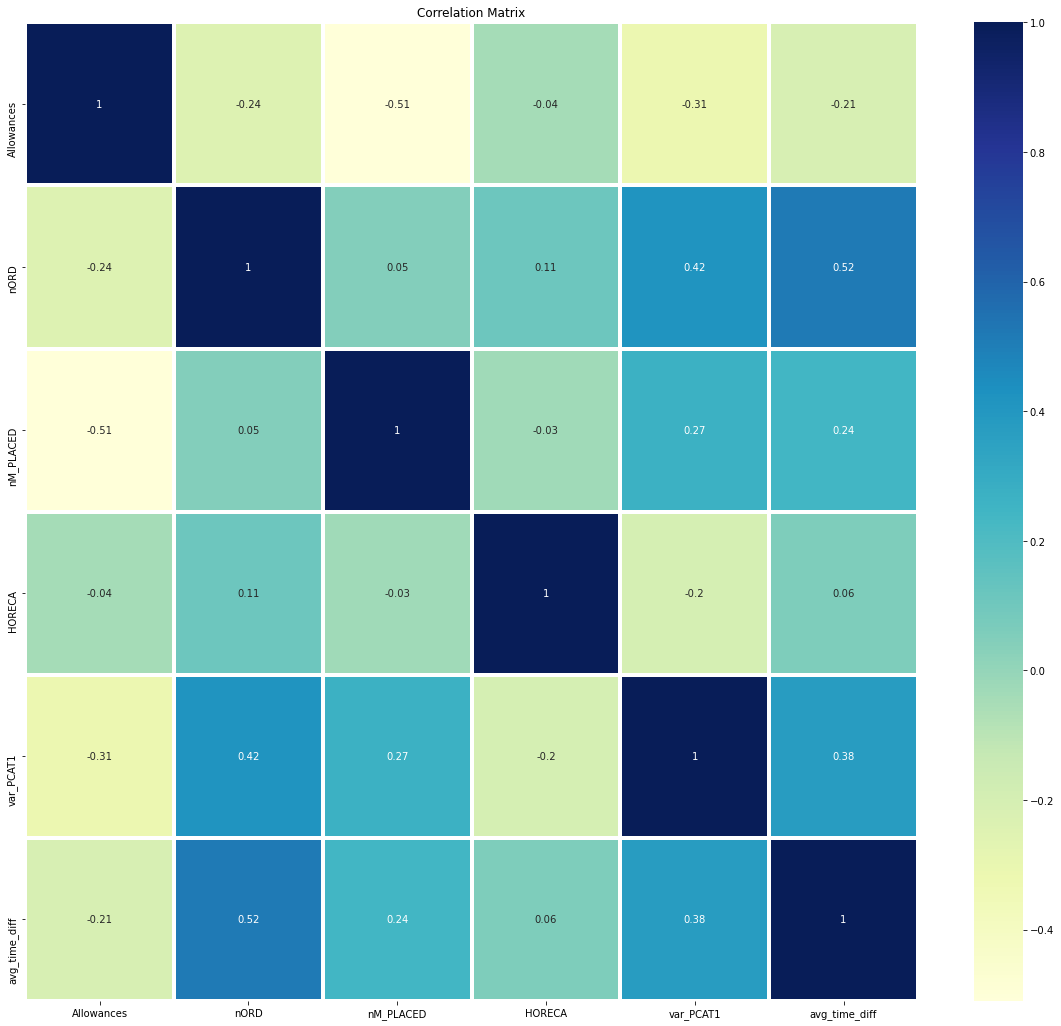

In [118]:
plt.figure(figsize=(20,18))
sns.heatmap(round(df[cols].corr(),2),annot=True, cmap='YlGnBu', linewidths=3, fmt='.2g')
plt.title('Correlation Matrix')
plt.show()

In [119]:
from sklearn.linear_model import LinearRegression

In [121]:
from sklearn.metrics import r2_score

In [123]:
#setting up a dictionary of dataframes5, with one for each cluster, for the Option with 5 Clusters
cluster5 = df.cluster5_descr.unique()
frames5={}
for i in cluster5:
    df_cluster = df[df.cluster5_descr == i]
    frames5[i] = df_cluster
    
for i in cluster5:
    X = frames5[i][cols]
    y= frames5[i]['NS']
    reg = LinearRegression().fit(X, y)
    frames5[i]['ns_predict'] = reg.predict(X)
    frames5[i]['diff_pred'] = frames5[i]['ns_predict']-frames5[i]['NS']
    frames5[i]['Potential']= np.where(frames5[i]['diff_pred']<= frames5[i]['diff_pred'].quantile(0.25),'Has big potential',
                                   np.where(frames5[i]['diff_pred']<= frames5[i]['diff_pred'].quantile(0.5),'still has potential','is performing above average'))
    
    print('X2 of regression for', i, " :", r2_score(frames5[i]['NS'],frames5[i]['ns_predict']))


X2 of regression for Clients fragiles  : 0.3049130631513898
X2 of regression for Le noyau  : 0.35571189280456916
X2 of regression for Les acheteurs de machines  : 0.6774561141484386
X2 of regression for Les gros consommateurs  : 0.506596338898885
X2 of regression for Cas exceptionnels  : 0.5964745195206422


In [124]:
##addingto the dictionary of dataframes6, with one for each cluster, for the Option with 6 Clusters
frames6={}
cluster6 = df.cluster6_descr.unique()
for i in cluster6:
    df_cluster = df[df.cluster6_descr == i]
    frames6[i] = df_cluster

#iterating over dataframes6, creating separate prediciton for each cluster
for i in cluster6:
    X = frames6[i][cols]
    y= frames6[i]['NS']
    reg = LinearRegression().fit(X, y)
    frames6[i]['ns_predict'] = reg.predict(X)
    #evaluating the relationship of the prediction and the true value for each case individually
    frames6[i]['diff_pred'] = frames6[i]['ns_predict']-frames6[i]['NS']
    frames6[i]['Potential']= np.where(frames6[i]['diff_pred']<= frames6[i]['diff_pred'].quantile(0.25),'Has big potential',
                                   np.where(frames6[i]['diff_pred']<= frames6[i]['diff_pred'].quantile(0.5),'still has potential','is performing above average'))
    
    print('X2 of regression for', i, " :", r2_score(frames6[i]['NS'],frames6[i]['ns_predict']))

X2 of regression for Clients fragiles  : 0.34304830318341517
X2 of regression for Le noyau  : 0.4043991014642495
X2 of regression for Les acheteurs de machines  : 0.6571618408981917
X2 of regression for le gros consommateur  : 0.12490755515016128
X2 of regression for Les acheteurs de Capsules  : 0.7066248661698153
X2 of regression for Cas exceptionnels  : 0.5933292060345464


In [126]:
print(frames5.keys())

df_names = []
for i in frames5.keys():
    temp_df = frames5[i]
    df_names.append(temp_df)

df_merged1 = pd.concat(df_names)

dict_keys(['Clients fragiles', 'Le noyau', 'Les acheteurs de machines', 'Les gros consommateurs', 'Cas exceptionnels'])


In [127]:
print(frames6.keys())

df_names = []
for i in frames6.keys():
    temp_df = frames6[i]
    df_names.append(temp_df)

df_merged2 = pd.concat(df_names)

dict_keys(['Clients fragiles', 'Le noyau', 'Les acheteurs de machines', 'le gros consommateur', 'Les acheteurs de Capsules', 'Cas exceptionnels'])


In [128]:
df_merged2 = df_merged2[['ns_predict','diff_pred','Potential']]

In [129]:
df_merged =df_merged1.join(df_merged2[['ns_predict','diff_pred','Potential']],lsuffix='5', rsuffix='6')

In [130]:
final=df_merged[['NS','cluster5_descr', 'cluster6_descr', 'ns_predict5', 'diff_pred5',
       'Potential5', 'ns_predict6', 'diff_pred6', 'Potential6']]

In [131]:
final

NS     cluster5_descr     cluster6_descr  ns_predict5  \
0      1041.0000   Clients fragiles   Clients fragiles   539.914009   
1       413.0000   Clients fragiles   Clients fragiles   457.385601   
2       807.5000   Clients fragiles   Clients fragiles   773.793660   
4        33.3334   Clients fragiles   Clients fragiles   502.408250   
5       244.0000   Clients fragiles   Clients fragiles   533.344385   
...          ...                ...                ...          ...   
47363   800.5000  Cas exceptionnels  Cas exceptionnels  1365.779002   
47383  4133.5200  Cas exceptionnels  Cas exceptionnels  4907.013361   
47648  3880.1500  Cas exceptionnels  Cas exceptionnels  3496.270172   
47704  1238.9000  Cas exceptionnels  Cas exceptionnels  1614.686095   
47733  4699.8400  Cas exceptionnels  Cas exceptionnels  4225.370029   

       diff_pred5                   Potential5  ns_predict6  diff_pred6  \
0     -501.085991            Has big potential   530.244636 -510.755364   
1       44.385601          still has potential   411.006648   -1.993352   
2      -33.706340          still has potential   791.177690  -16.322310   
4      469.074850  is performing above average   490.585694  457.252294   
5      289.344385  is performing above average   523.441067  279.441067   
...           ...                          ...          ...         ...   
47363  565.279002  is performing above average  1407.066563  606.566563   
47383  773.493361  is performing above average  4881.640680  748.120680   
47648 -383.879828          still has potential  3500.353155 -379.796845   
47704  375.786095  is performing above average  1655.581620  416.681620   
47733 -474.469971          still has potential  4218.199352 -481.640648   

                        Potential6  
0                Has big potential  
1              still has potential  
2              still has potential  
4      is performing above average  
5      is performing above average  
...                            ...  
47363  is performing above average  
47383  is performing above average  
47648          still has potential  
47704  is performing above average  
47733          still has potential  

[48000 rows x 9 columns]

---------